In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
import scipy.io as sio
from matplotlib import rc

def set_style_sns():
    sns.set_context('paper')
    sns.set(font = 'serif')
    sns.set(font_scale = 1.3)
    
    sns.set_style('white', {
        'font.family': 'serif',
        'font.serif': ['Time', 'Palatino', 'serif'],
        'lines.markersize': 10
    })
    
    
plt.rcParams.update({'font.size':16})
set_style_sns()

plt.rcParams.update({'text.usetex': False})

In [2]:
data = sio.matlab.loadmat('./../data/ece271b_data_select.mat')

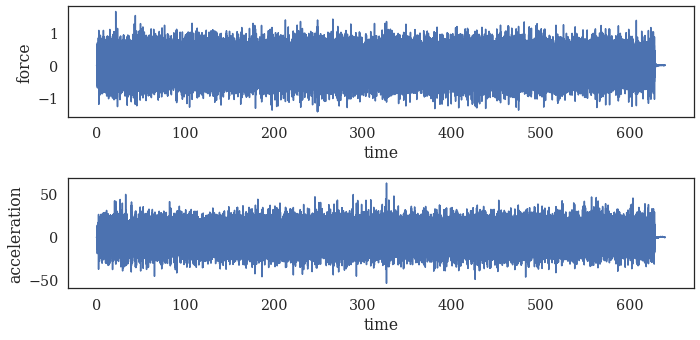

In [3]:
u = np.array(data['u'])
y = np.array(data['y'])
t = np.array(data['time'])[:,0]
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t,u)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(t,y)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

3276


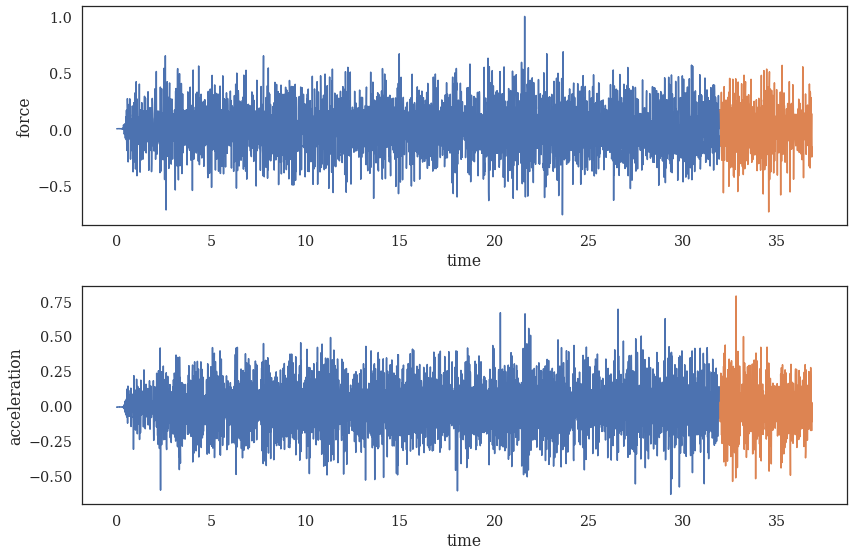

In [4]:
umax = np.max(u)
ymax = np.max(y)

u_norm = u/umax
y_norm = y/ymax

N = len(u)
ntrain = int(N*0.05)

print(ntrain)
utrain = u_norm[:ntrain]
ytrain = y_norm[:ntrain]
ttrain = t[:ntrain]
intrain = np.hstack([utrain,ytrain])

utest = u_norm[ntrain:ntrain+500]
ytest = y_norm[ntrain:ntrain+500]
ttest = t[ntrain:ntrain+500]
intest = np.hstack([utest,ytest])

plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.plot(ttrain,utrain)
plt.plot(ttest,utest)
plt.xlabel('time')
plt.ylabel('force')

plt.subplot(2,1,2)
plt.plot(ttrain,ytrain)
plt.plot(ttest,ytest)
plt.xlabel('time')
plt.ylabel('acceleration')

plt.tight_layout()
plt.show()

In [26]:
def create_inout_sequences(input_data, output_data, tw):
    xs = []
    ys = []

    for i in range(len(input_data)-tw-1):
        x = input_data[i:(i+tw), :]
        y = output_data[i+tw]

        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [28]:
train_window = 30

x_train, y_train = create_inout_sequences(intrain, ytrain, train_window)
x_val, y_val = create_inout_sequences(intest, ytest, train_window)

x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float()

x_val = torch.from_numpy(x_val).float()
y_val = torch.from_numpy(y_val).float()

print(x_train.shape, y_train.shape)

torch.Size([3245, 30, 2]) torch.Size([3245, 1])


In [34]:
import torch.nn as nn
import torch.optim as optim

class LSTM(nn.Module):

    def __init__(self, n_features, n_hidden, seq_len, n_layers=2):
        super(LSTM, self).__init__()
        self.n_hidden = n_hidden
        self.seq_len = seq_len
        self.n_layers = n_layers
        self.lstm = nn.LSTM(
          input_size=n_features,
          hidden_size=n_hidden,
          num_layers=n_layers,
          dropout=0.5
        )

        self.linear = nn.Linear(in_features=n_hidden, out_features=1)

    def reset_hidden_state(self):
        self.hidden = (
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden),
            torch.zeros(self.n_layers, self.seq_len, self.n_hidden)
        )

    def forward(self, sequences):
        lstm_out, self.hidden = self.lstm(
          sequences.view(len(sequences), self.seq_len, -1),
          self.hidden
        )

        last_time_step = \
          lstm_out.view(self.seq_len, len(sequences), self.n_hidden)[-1]
        y_pred = self.linear(last_time_step)

        return y_pred

In [37]:
def train_model(
    model,
    X_train,
    y_train,
    X_test=None,
    y_test=None
    ):

    loss_fn = torch.nn.MSELoss(reduction='sum')
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    num_epochs = 60

    train_hist = np.zeros(num_epochs)
    test_hist = np.zeros(num_epochs)

    for t in range(num_epochs):
        model.reset_hidden_state()
        y_pred = model(X_train)
        loss = loss_fn(y_pred.float(), y_train)
        
    if test_data is not None:
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred.float(), y_test)
        test_hist[t] = test_loss.item()

        if t % 10 == 0:
            print(f'Epoch {t} train loss: {loss.item()} test loss: {test_loss.item()}')

    elif t % 10 == 0:
        print(f'Epoch {t} train loss: {loss.item()}')

    train_hist[t] = loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimiser.step()

    return model.eval(), train_hist, test_hist

In [ ]:
model = LSTM(
    n_features=2,
    n_hidden=512,
    seq_len=train_window,
    n_layers=2
    )

model, train_hist, test_hist = train_model(
    model,
    x_train,
    y_train,
    x_val,
    y_val)

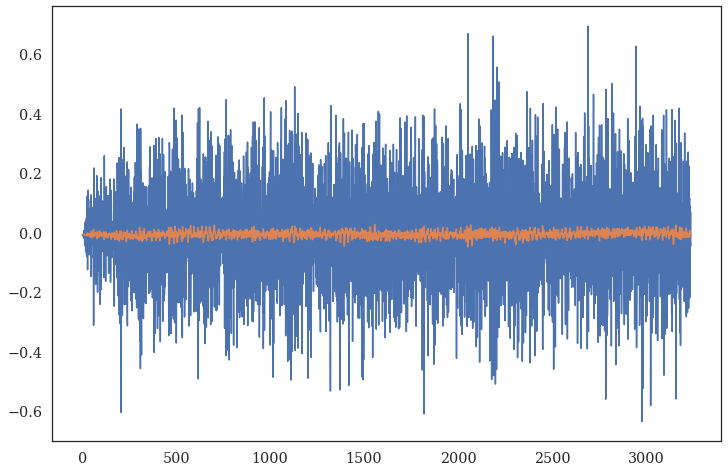

In [171]:
actual_1, predicted_1, test_loss_1 = optimization_1.evaluate(x_train, y_train, future=5, batch_size=30)
actual_1 = np.array(actual_1)

plt.figure(figsize=(12,8))
plt.plot(actual_1)
plt.plot(predicted_1)
plt.show()


In [156]:
y_val.shape

torch.Size([452, 48])